# Getting back into fastai with fastbook

In [ ]:
from fastai.vision.all import *

Explore file structure and a random image from the three's dataset.

In [ ]:
path = untar_data(URLs.MNIST_SAMPLE)
Path.BASE_PATH = path # set the BASE_PATH to the data path for readability

In [ ]:
path.ls()

(#3) [Path('valid'),Path('labels.csv'),Path('train')]

In [ ]:
(path/'train').ls()

(#2) [Path('train/7'),Path('train/3')]

In [ ]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()

In [ ]:
im3_path = threes[1]
im3 = Image.open(im3_path)
im3

In [ ]:
tensor(im3)[:10,:10]

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,  29],
        [  0,   0,   0,   0,   0,   0,   0,  48, 166, 224],
        [  0,   0,   0,   0,   0,  93, 244, 249, 253, 187],
        [  0,   0,   0,   0,   0, 107, 253, 253, 230,  48],
        [  0,   0,   0,   0,   0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

In [ ]:
im3t = tensor(im3)
df = pd.DataFrame(im3t[:20,:20])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0
6,0,0,0,0,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0
7,0,0,0,0,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0
8,0,0,0,0,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0
9,0,0,0,0,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0


Stack all of the images for each category into a tensor of (#ims, img_w, img_h)

In [ ]:
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
len(three_tensors), len(seven_tensors)

(6131, 6265)

In [ ]:
three_train = torch.stack(three_tensors).float()/255
seven_train = torch.stack(seven_tensors).float()/255
three_train.shape

torch.Size([6131, 28, 28])

Find the "ideal 3" and "ideal 7": the avg pixel value for the three imgs and seven imgs.

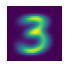

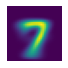

In [ ]:
mean3 = three_train.mean(0)
mean7 = seven_train.mean(0)
show_image(mean3); show_image(mean7);

Create validation sets.

In [ ]:
three_valid = torch.stack([tensor(Image.open(o)) for o in threes]).float()/255
seven_valid = torch.stack([tensor(Image.open(o)) for o in sevens]).float()/255

Broadcasting review!

Element-wise operations: elements in memory are matched up.

In [ ]:
tensor([1,2,3]) + tensor([1,1,1])

tensor([2, 3, 4])

Broadcasting: since there aren't enough elements on the left to match up with the tensor on the right, the tensor is copied as many times as necessary, then they're matched up and computed. When broadcasting, the copies are NOT stored in memory, so the computation is lightning-fast.

In [ ]:
tensor([[1,2],[3,4],[5,6]]) - tensor([1,1])

tensor([[0, 1],
        [2, 3],
        [4, 5]])

Training set x's is just the three tensors and seven tensors together. We've also transformed their shapes so that each img is a row of pixels instead of a grid of pixels.

In [ ]:
train_x = torch.cat([three_train, seven_train]).view(-1, 28*28)
train_x.shape

torch.Size([12396, 784])

Training set y's: basically a spreadsheet with one column and len(train_x) rows. The val for each row is either 1 (a three) or 0 (a seven).

".unsqueeze(1)" turns a vector into a matrix.

In [ ]:
train_y = tensor([1]*len(three_train) + [0]*len(seven_train)).unsqueeze(1)
train_y.shape
train_y[0:10]

tensor([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]])

Create pytorch dataset for training data.

In [ ]:
ds = list(zip(train_x, train_y))
x,y = ds[0]
x.shape, y

(torch.Size([784]), tensor([1]))

Create valid dataset.

In [ ]:
valid_x = torch.cat([three_valid, seven_valid]).view(-1, 28*28)
valid_y = tensor([1]*len(three_valid) + [0]*len(seven_valid)).unsqueeze(1)
ds_valid = list(zip(valid_x, valid_y))

The model is weights*pixels + bias, with pixels being the image tensors. We'll create a function to initialize the "weights" and "bias" params.

In [ ]:
def init_params(size, var=1.0): return (torch.randn(size)*var).requires_grad_()

In [ ]:
weights = init_params((28*28, 1))
bias = init_params(1)

Let's get a prediction from the untrained model.

In [ ]:
(train_x[0]*weights.T).sum() + bias

tensor([-5.9167], grad_fn=<AddBackward0>)

Calc all the preds.

In [ ]:
def linear1(xb): return xb@weights + bias
preds = linear1(train_x)
preds

tensor([[-5.9167],
        [-0.5423],
        [-3.4363],
        ...,
        [-7.6793],
        [ 2.6860],
        [ 5.1304]], grad_fn=<AddBackward0>)

How did we do?

In [ ]:
corrects = (preds>0.0).float() == train_y
corrects

tensor([[False],
        [False],
        [False],
        ...,
        [ True],
        [False],
        [False]])

In [ ]:
corrects.float().mean().item()

0.28864148259162903

As expected – random weights = random guess... coin toss! Perfect.

Now, to make a loss function. This candidate function will return the correctness-adjusted confidence:

In [ ]:
def conf_adj_corr(preds, targs):
    return torch.where(targs==1, 1-preds, preds).mean()

It will only work on numbers between 0 and 1. We'll transform the model outputs with sigmoid.

In [ ]:
def sigmoid(x):
    return 1/(1+torch.exp(-x))

Together:

In [ ]:
def loss(preds, targs):
    return conf_adj_corr(preds.sigmoid(), targs)

LEFT OFF HERE

https://192.168.0.109:9999/notebooks/repos/fastbook/04_mnist_basics.ipynb

Section "SGD and Mini-Batches" (4/5ths down the nb)